## 계층적 군집(4) - EastWestAirlines Data
>###### EastWestAirlines 파일에는 항공사의 상용 고객 프로그램에 속한 승객에 대한 정보가 포함되어 있습니다.
>###### 각 승객에 대한 데이터에는 마일리지 내역 및 적립 방식에 대한 정보가 포함됩니다
>###### 다양한 유형의 마일리지 제공에 대해 다양한 세그먼트를 타겟팅할 목적으로 사용됩니다.

#### 군집분석에서 중요한 점
1) 너무 많은 변수를 사용할 위험
###### 변수를 이것 저것 다 넣으면 기계가 알아서 잘 해 주겠지.. 하는 기대심리를 경계

##### 변수를 너무 많이 넣을 경우
###### 1. 알고리즘이 실행시간 증가
###### 2. 모델이 복잡해 지면서 과적합 위험 증가
###### 3. 결과 검토에 대한 난이도 증가

2) 변수간 관계 미리보기
##### 변수간 상관관계 확인
###### 1. 상관계수 히트맵
###### 2. 산점도 행렬
##### 주성분(PCA)분석 활용하기
##### 주성분 분석은 데이터의 특징을 최대한 손실 없이 살리면서 데이터의 차원을 축소하는 기법.
##### 클러스터링은 분석에서도 취급하는 변수의 수를 줄일 때 유용하게 사용할 수 있다.

3) 그 밖의 내용
###### 1. 문자열 데이터 X
###### 2. 이상치에 민감하므로 이상치 정제 혹은 표준화를 수행할것

#### 군집분석의 결과
###### 비지도 학습이므로 정답이 없는 상태에서 시작하므로 훈련 데이터와 검증 데이터를 분할할 필요가 없다.
###### 군집의 결과 역시 정답이 아닐 수 있다.
###### 적용 가능한 하이퍼 파라미터들을 다양하게 설정하여 시각화 결과가 가장 고르게 군집을 형성하는 경우를 선택한다. 선택 기준에 실루엣 점수를 반영하는 것도 고려할 수 있다.

#### #01. 패키지 가져오기


In [1]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
import numpy as np
from itertools import product
from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, Normalizer

#### #02. 데이터 가져오기
- Balance : 보너스 여행에 적합한 마일리지
- Qual_miles : Topflight 자격 취득에 필요한 마일리지 수
- cc1_miles : 지난 12개월 동안의 신용카드 사용에 의해 적립된 마일리지
- cc2_miles : 지난 12개월 동안 Rewards 신용카드로 적립한 마일리지
- cc3_miles : 지난 12개월 동안 법인카드로 적립한 마일리지
- Bonus_miles : 지난 12개월 동안 항공권 외 보너스 거래를 통해 적립된 마일리지
- Bonus_trans : 지난 12개월 동안 항공권 외 보너스 거래 수
- Flight_miles_12mo : 지난 12개월간 비행 마일리지
- Flight_trans_12 : 지난 12개월간 항공권 거래 건수
- Days_since_enroll : 프로그램에 가입한 일수
- Award : 보너스 항공권을 받았는지 여부

In [2]:
origin = read_excel("https://data.hossam.kr/G02/EastWestAirlines.xlsx",
index_col='ID')
print(origin.info())
origin.head()


<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 1 to 4021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award              3999 non-null   int64
dtypes: int64(11)
memory usage: 374.9 KB
None


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0
2,19244,0,1,1,1,215,2,0,0,6968,0
3,41354,0,1,1,1,4123,4,0,0,7034,0
4,14776,0,1,1,1,500,1,0,0,6952,0
5,97752,0,4,1,1,43300,26,2077,4,6935,1


#### 03. 이상치 확인

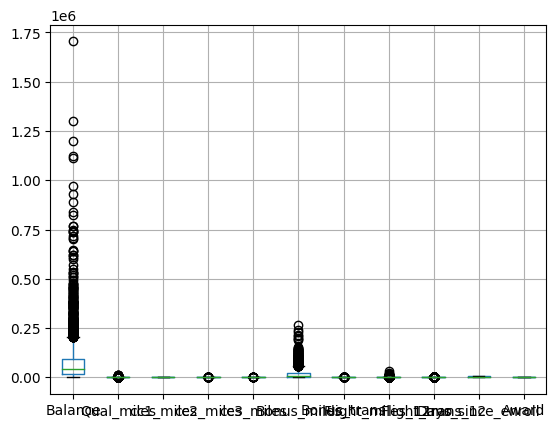

In [3]:
origin.boxplot()
plt.show()
plt.close()

> ###### 다수의 이상치가 발견되므로 데이터 스케일링을 수행함

#### #04. 데이터 표준화

In [4]:
scaler = StandardScaler()
n_data = scaler.fit_transform(origin)
ndf = DataFrame(n_data, columns=origin.columns, index=origin.index)
ndf.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,-0.451141,-0.186299,-0.769578,-0.098242,-0.062767,-0.702786,-1.104065,-0.328603,-0.362168,1.395454,-0.766919
2,-0.539457,-0.186299,-0.769578,-0.098242,-0.062767,-0.701088,-0.999926,-0.328603,-0.362168,1.379957,-0.766919
3,-0.320031,-0.186299,-0.769578,-0.098242,-0.062767,-0.539253,-0.791649,-0.328603,-0.362168,1.411920,-0.766919
4,-0.583799,-0.186299,-0.769578,-0.098242,-0.062767,-0.689286,-1.104065,-0.328603,-0.362168,1.372208,-0.766919
5,0.239678,-0.186299,1.409471,-0.098242,-0.062767,1.083121,1.499394,1.154932,0.692490,1.363975,1.303918


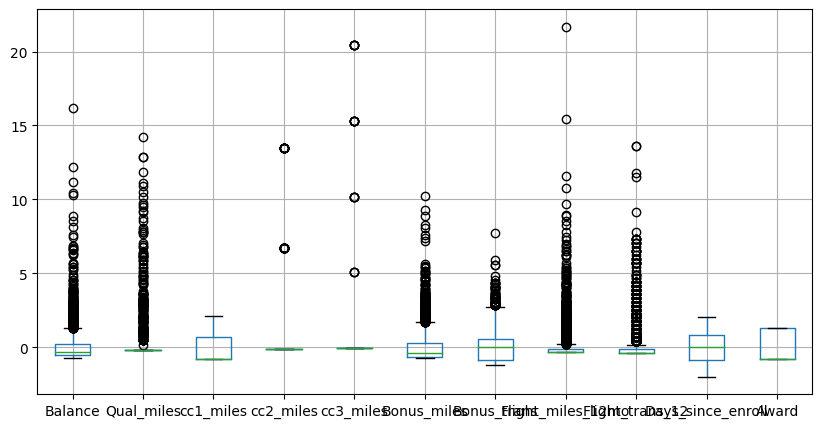

In [5]:
plt.figure(figsize=(10, 5))
ndf.boxplot()
plt.show()
plt.close()

#### #05. 기초 통계량 확인

In [6]:
ndf.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
count,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3.999000e+03,3999.000000,3.999000e+03,3.999000e+03,3.999000e+03
mean,2.842882e-17,6.574164e-17,1.705729e-16,3.038330e-16,1.350369e-16,-2.842882e-17,-7.817925e-17,0.000000,1.776801e-17,5.685763e-17,1.421441e-17
std,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125,1.000125e+00,1.000125e+00,1.000125e+00
min,-7.304396e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-7.099918e-01,-1.208203e+00,-0.328603,-3.621679e-01,-1.993611e+00,-7.669193e-01
25%,-5.465676e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-6.582276e-01,-8.957878e-01,-0.328603,-3.621679e-01,-8.661823e-01,-7.669193e-01
50%,-3.027332e-01,-1.862987e-01,-7.695784e-01,-9.824189e-02,-6.276658e-02,-4.130308e-01,4.145743e-02,-0.328603,-3.621679e-01,-1.092530e-02,-7.669193e-01
75%,1.866028e-01,-1.862987e-01,6.831212e-01,-9.824189e-02,-6.276658e-02,2.756198e-01,5.621492e-01,-0.106466,-9.850333e-02,8.097050e-01,1.303918e+00
max,1.618884e+01,1.422486e+01,2.135821e+00,1.344898e+01,2.042732e+01,1.020957e+01,7.747696e+00,21.683004,1.361205e+01,2.023095e+00,1.303918e+00


#### #06. 각 변수간의 상관관계 확인

<Figure size 640x480 with 0 Axes>

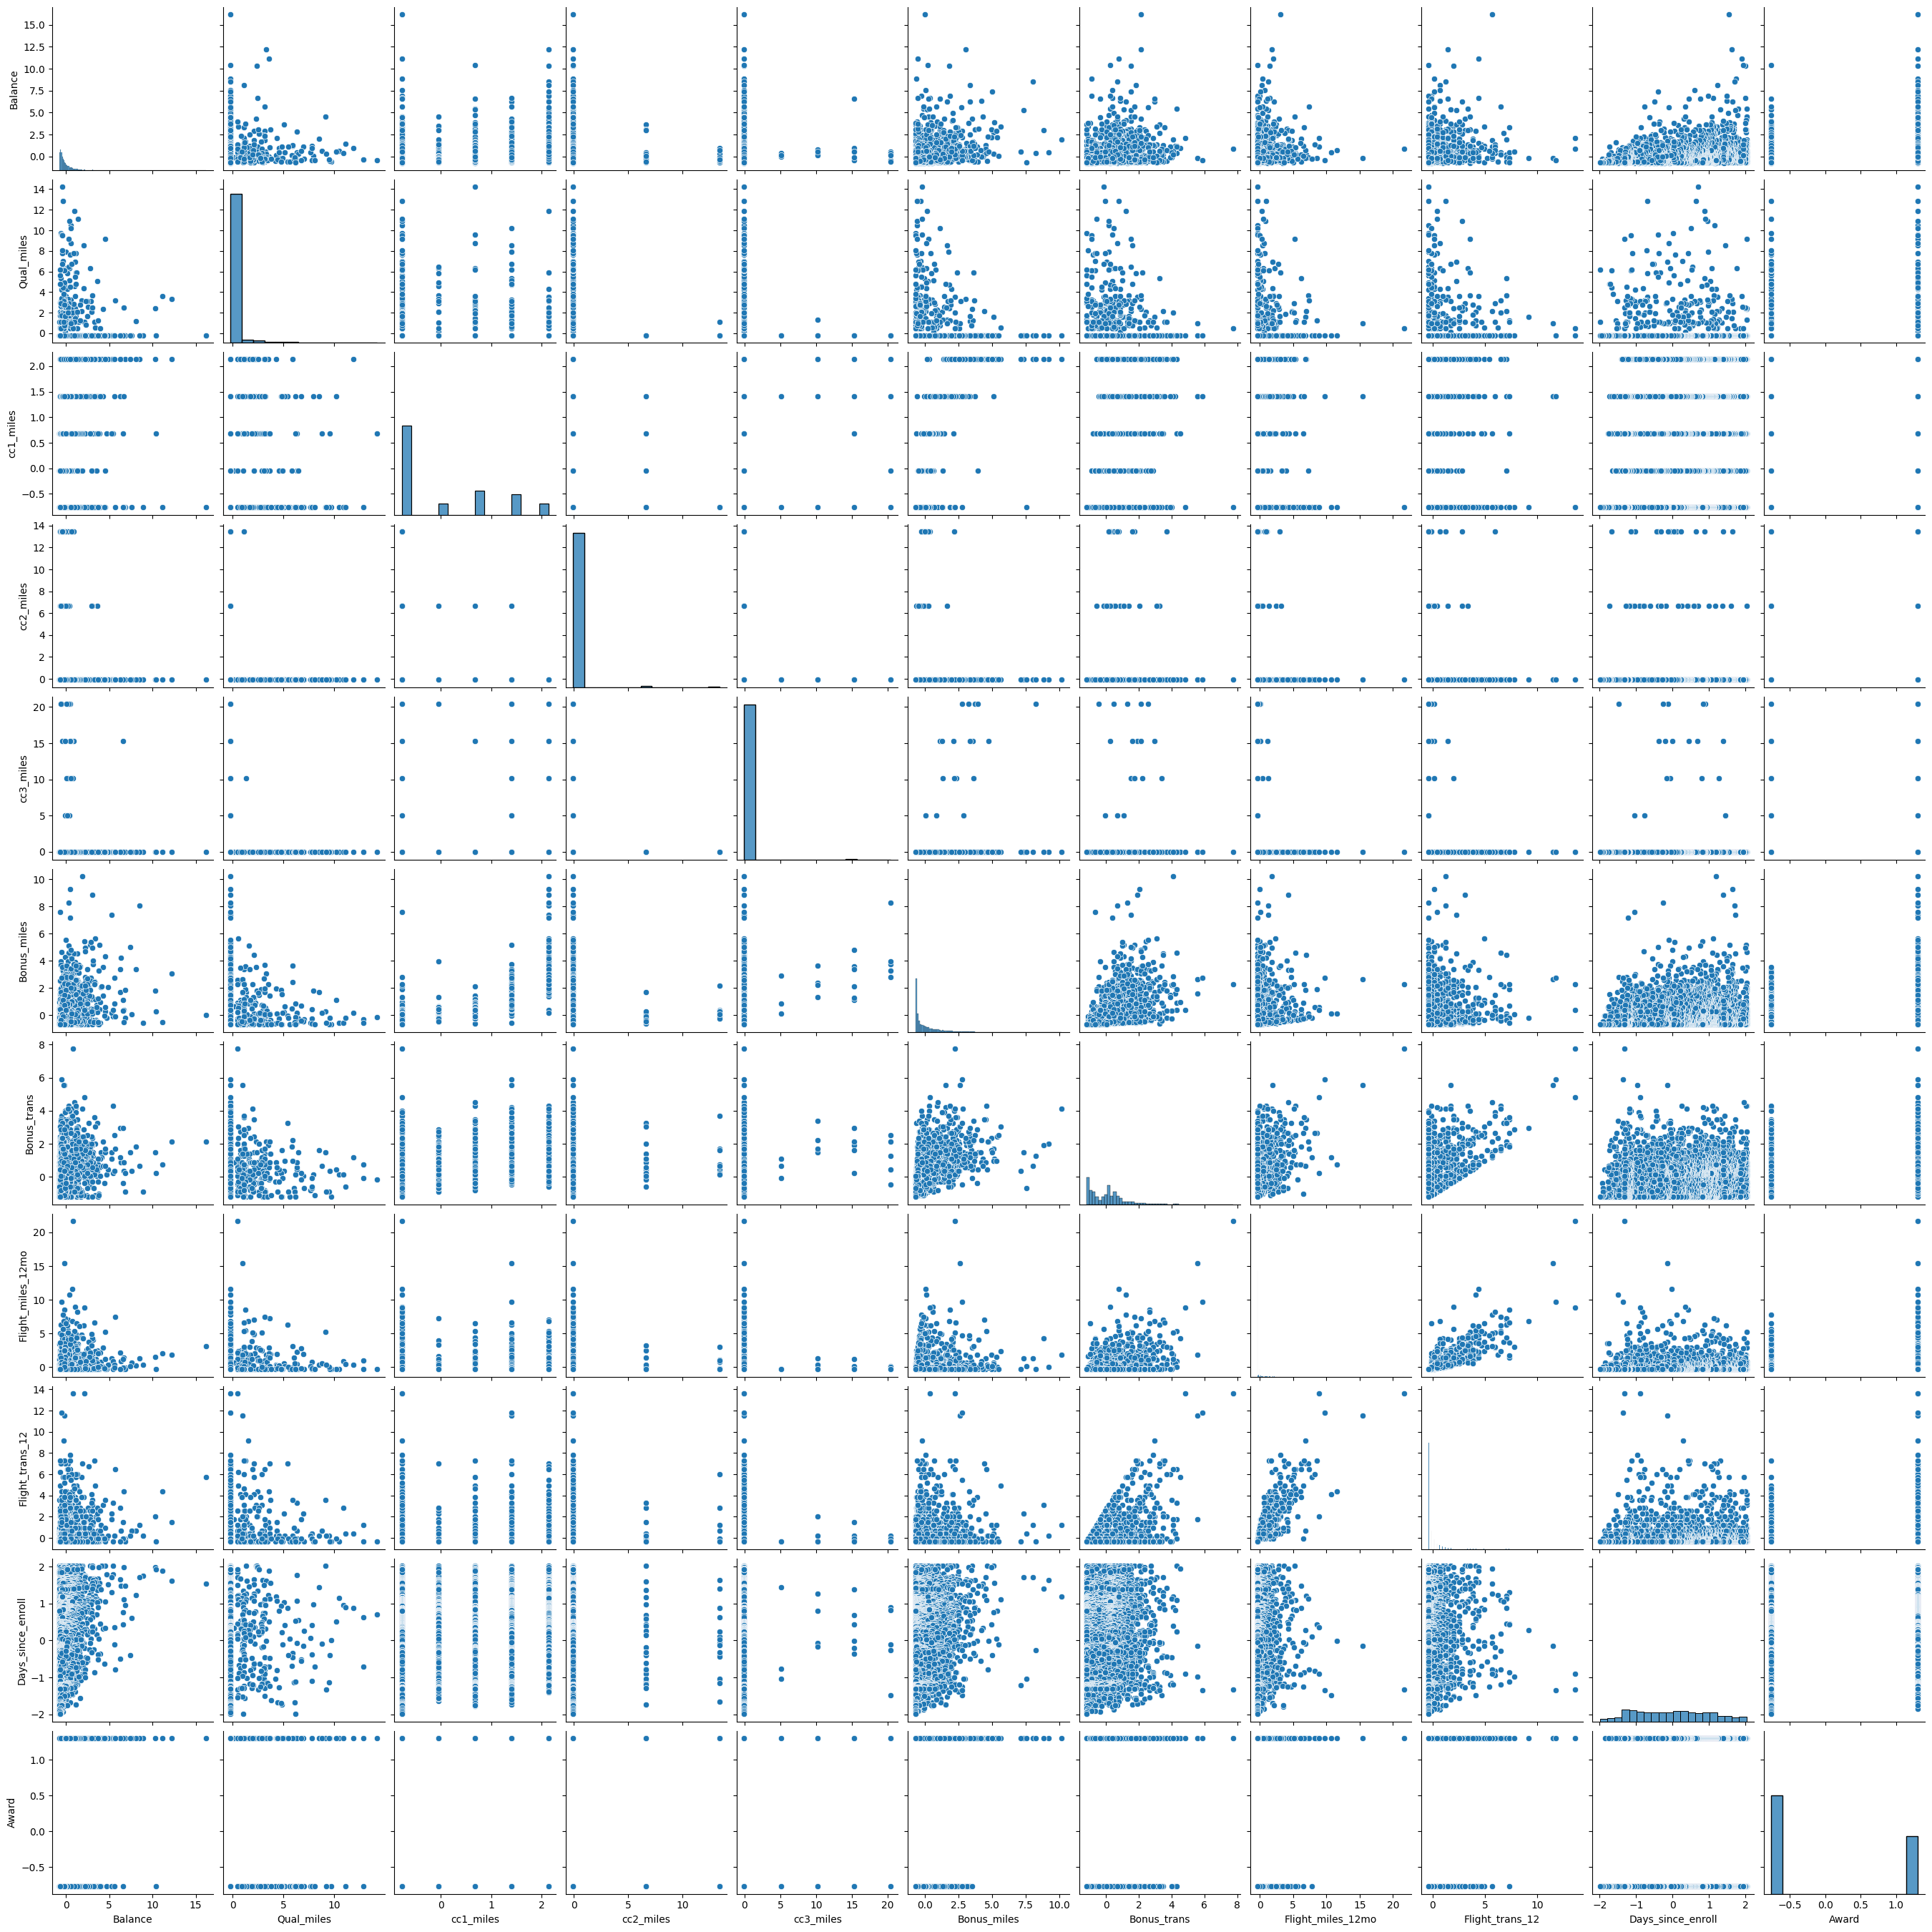

In [7]:
plt.figure()
sb.pairplot(ndf)
plt.show()
plt.close()

#### #07. 상관계수 히트맵

##### 히트맵을 통해서 특별히 높은 상관을 보이는 변수 묶음들이 있는지 확인 가능
##### 묶음 별로 상대적으로 중요도가 낮다고 판단되는 변수는 분석에서 제외할 수 있다.

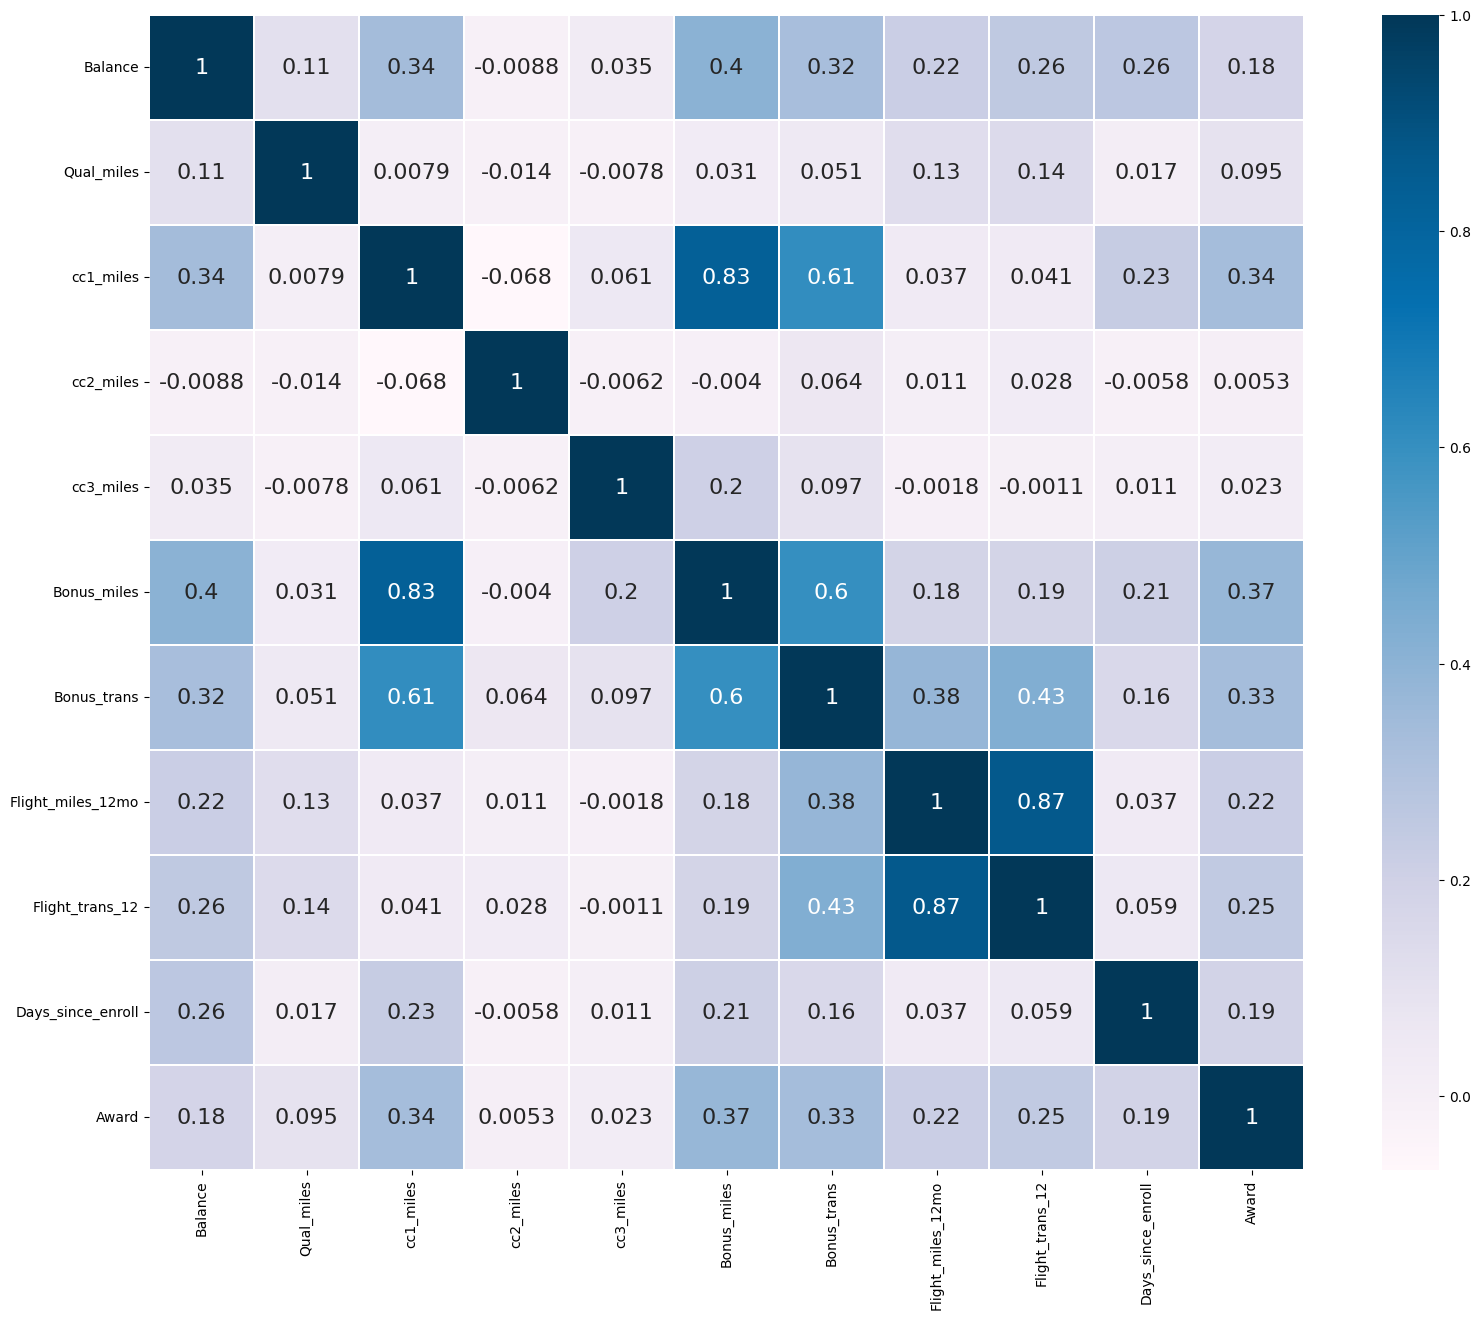

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=(20, 15))
sb.heatmap(ndf.corr(), linewidths = 0.1, vmax = 1.0,
square = True, cmap = plt.cm.PuBu,
linecolor = "white", annot = True,
annot_kws = {"size" : 16})
plt.show()
plt.figure()


#### #08. 대상 변수 필터링

In [9]:
# 예제 구성을 위해 테스트 한 다른 변수집합들
# -> 모두 3개의 군집을 형성하였음
#x = ndf.filter(['Balance','cc1_miles','Bonus_miles','Bonus_trans',
# 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll'])
#x = ndf.filter(['Balance','cc1_miles','cc2_miles','cc3_miles','Bonus_miles',
# 'Bonus_trans', 'Days_since_enroll'])
# 최종 선정된 변수집합
x = ndf.filter(['Balance','cc1_miles','Bonus_miles','Bonus_trans',
'Flight_miles_12mo', 'Flight_trans_12'])
x.head()

,Balance,cc1_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12
ID,,,,,,
1,-0.451141,-0.769578,-0.702786,-1.104065,-0.328603,-0.362168
2,-0.539457,-0.769578,-0.701088,-0.999926,-0.328603,-0.362168
3,-0.320031,-0.769578,-0.539253,-0.791649,-0.328603,-0.362168
4,-0.583799,-0.769578,-0.689286,-1.104065,-0.328603,-0.362168
5,0.239678,1.409471,1.083121,1.499394,1.154932,0.692490


#### 군집분석 수행

In [10]:
#method = ['single', 'complete', 'average', 'weighted', 'centroid', 'ward']
method = ['single', 'complete', 'average', 'ward']
metric = ['euclidean', 'cityblock']
# 두 개의 리스트 조합
prod = list(product(*[method, metric]))
prod

[('single', 'euclidean'),
 ('single', 'cityblock'),
 ('complete', 'euclidean'),
 ('complete', 'cityblock'),
 ('average', 'euclidean'),
 ('average', 'cityblock'),
 ('ward', 'euclidean'),
 ('ward', 'cityblock')]

<Figure size 640x480 with 0 Axes>

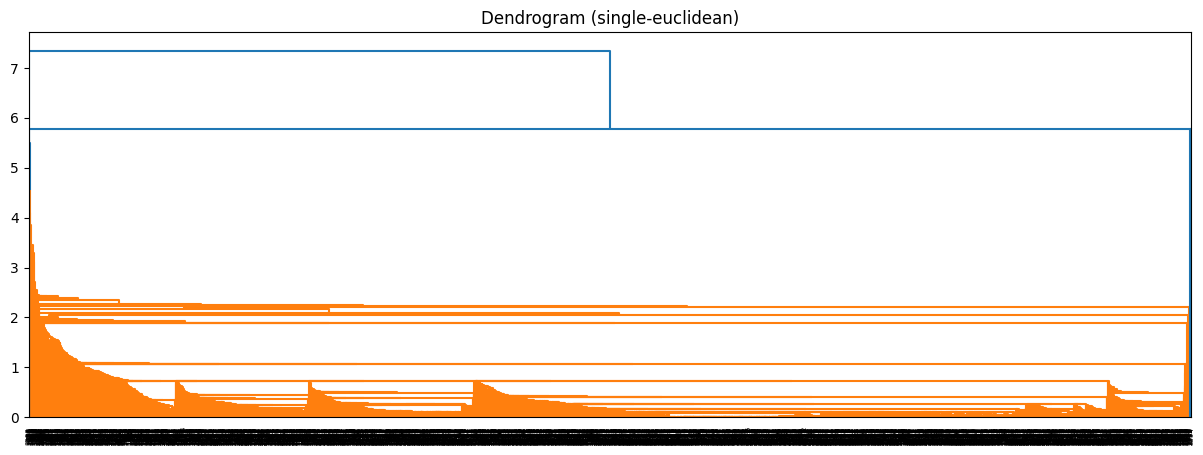

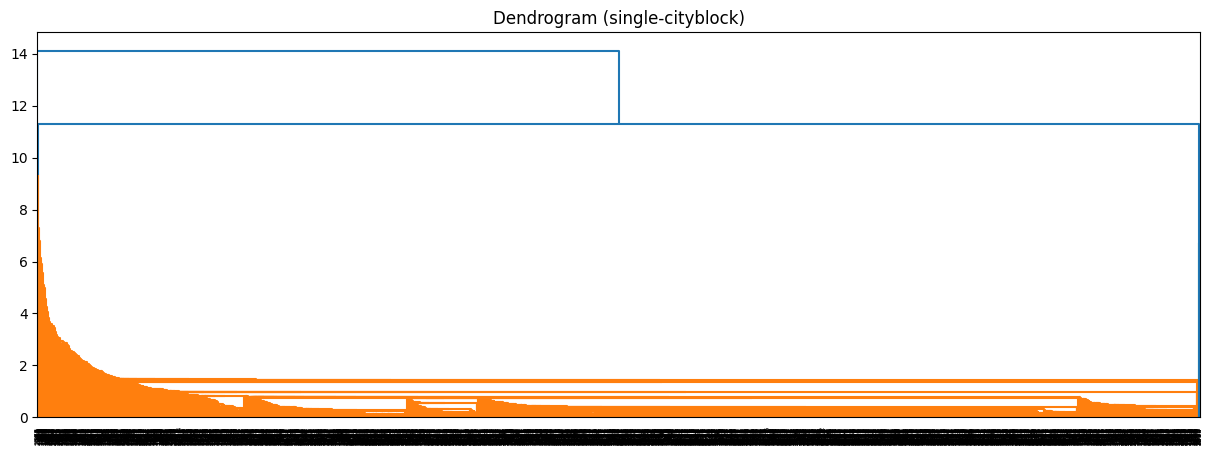

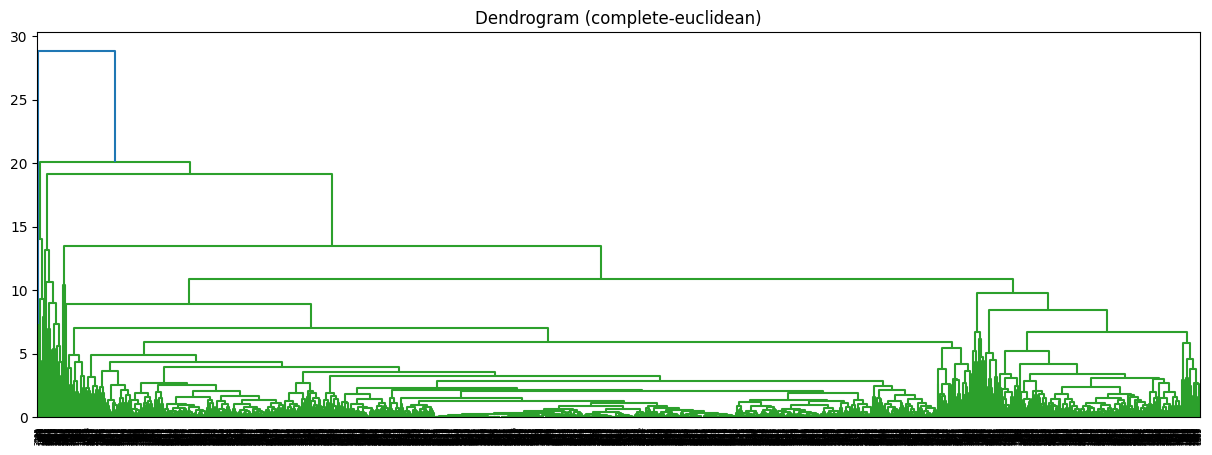

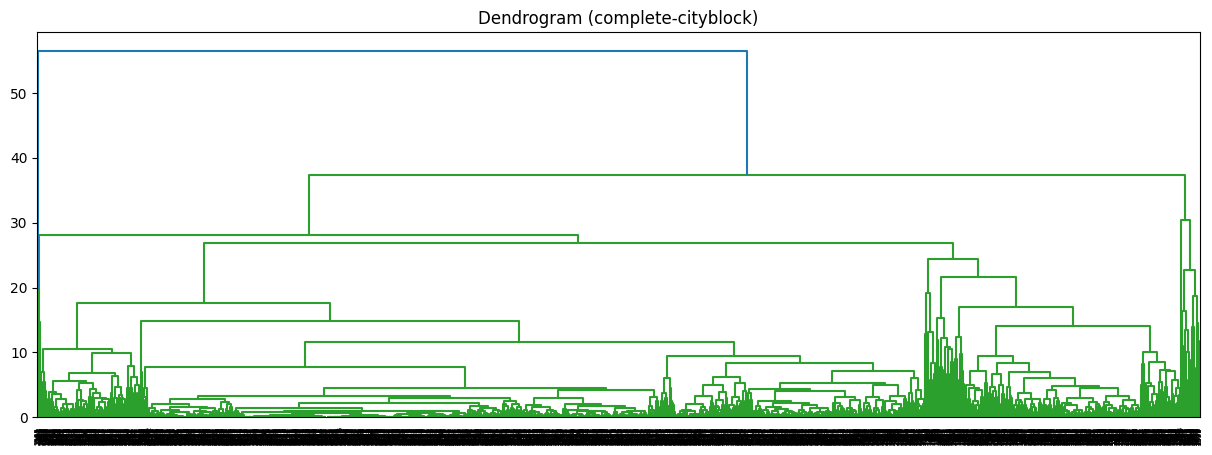

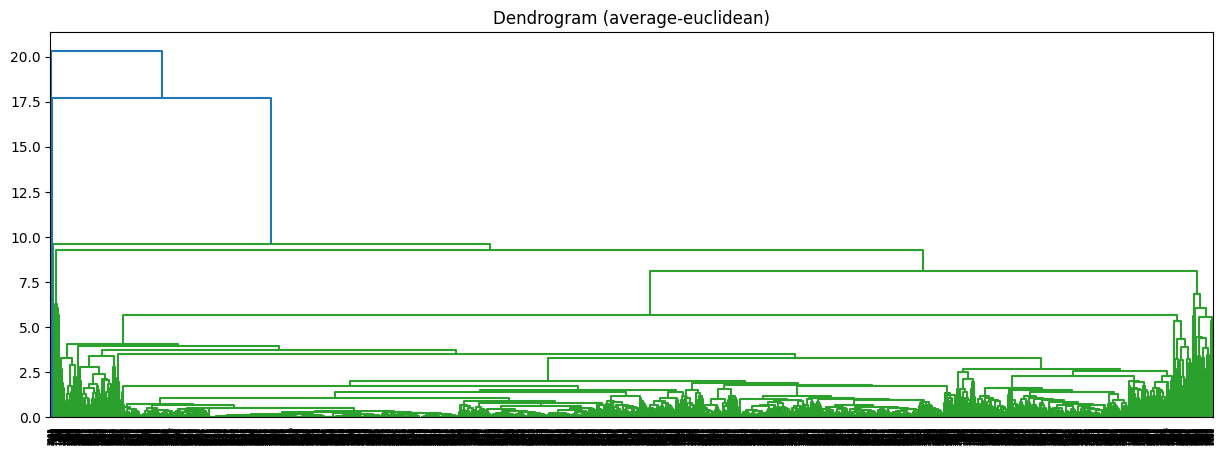

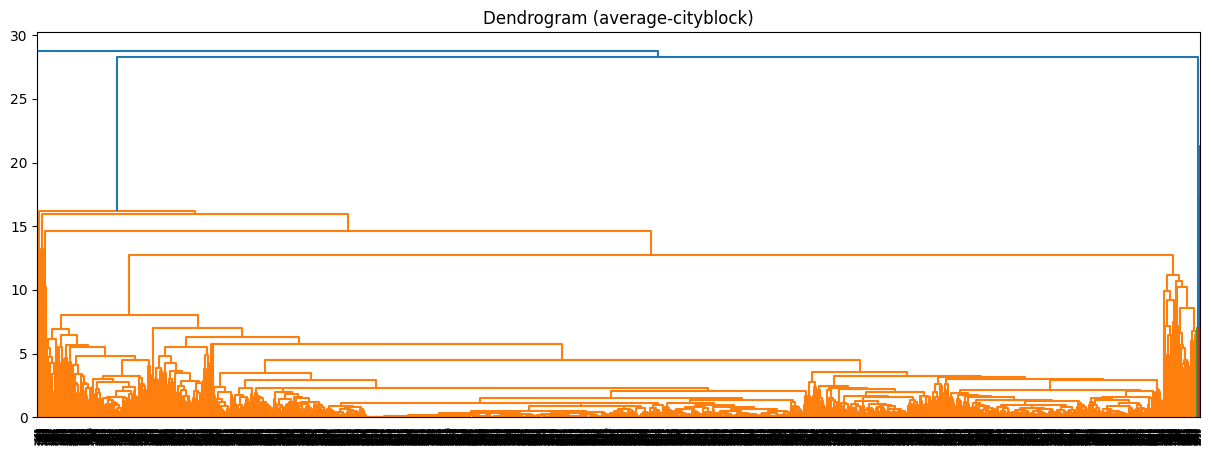

ValueError: Method 'ward' requires the distance metric to be Euclidean

In [12]:
for method, metric in prod:
    if method in ['centroid','ward'] and metric == 'euclidean':
        continue
    z = linkage(x, method=method, metric=metric)
    plt.figure(figsize=(15, 5))
    dendrogram(z)
    plt.title(f'Dendrogram ({method}-{metric})')
    plt.show()
    plt.close()

#### #10. 군집 결과값을 sklearn 패키지에 적용

###### 각 개별 데이터가 어떤 군집에 속하는가를 알아보기 위해서는 sklearn을 사용하는 것이 간편하다.

In [ ]:
h_complete = AgglomerativeClustering(n_clusters=3, metric='cityblock',
linkage='complete')
h_complete.fit(x)
h_complete.labels_


In [ ]:
origin['Cluster'] = h_complete.labels_
origin.head()

In [ ]:
origin['Cluster'].value_counts()


VIF 고객 등급

In [ ]:
origin.query('Cluster = 1')